<a href="https://colab.research.google.com/github/poojan14/AIMS/blob/main/AT_case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [27]:
download = drive.CreateFile({'id':'18T0AsBbdxw2NYdtSHDzpHPj8GzcYfUGX'})
download.GetContentFile('AIMS_WQMS.csv')
import pandas as pd
import numpy as np
df=pd.read_csv('AIMS_WQMS.csv')


In [28]:
df.head(5)

,date_time,date,time,seconds_1970,Humidity,PAR,Water_Temperature,Air_Temperature,Air_Pressure
0,2020-08-06T00:00:00+1000,06-08-2020,00:00:00,1.600000e+09,73.0,0.123420,22.57,22.2,1014.0
1,2020-08-06T00:10:00+1000,06-08-2020,00:10:00,1.600000e+09,71.8,0.080995,22.57,22.3,1013.7
2,2020-08-06T00:20:00+1000,06-08-2020,00:20:00,1.600000e+09,71.9,0.119561,22.58,22.3,1013.8
3,2020-08-06T00:30:00+1000,06-08-2020,00:30:00,1.600000e+09,71.1,0.069422,22.57,22.2,1013.5
4,2020-08-06T00:40:00+1000,06-08-2020,00:40:00,1.600000e+09,73.9,0.046282,22.56,22.2,1013.6


In [29]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


In [30]:
df = df[5::6]
df['Date_Time']=pd.to_datetime(df['date']+' '+df['time'])

In [31]:
Date_Time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')
# Converting time data into signal form for better meaning
timestamp_s = Date_Time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df.head(5)


,date,time,seconds_1970,Humidity,PAR,Water_Temperature,Air_Temperature,Air_Pressure,Date_Time,Day sin,Day cos,Year sin,Year cos
5,06-08-2020,00:50:00,1.600000e+09,73.8,0.030855,22.56,22.3,1013.5,2020-06-08 00:50:00,-0.675590,-0.737277,-0.564553,-0.825397
11,06-08-2020,01:50:00,1.600000e+09,74.0,0.150413,22.56,22.3,1013.2,2020-06-08 01:50:00,-0.843391,-0.537300,-0.565145,-0.824992
17,06-08-2020,02:50:00,1.600000e+09,70.9,0.042424,22.55,22.5,1012.8,2020-06-08 02:50:00,-0.953717,-0.300706,-0.565736,-0.824586
23,06-08-2020,03:50:00,1.600000e+09,68.3,0.073280,22.55,22.5,1012.5,2020-06-08 03:50:00,-0.999048,-0.043619,-0.566327,-0.824181
29,06-08-2020,04:50:00,1.600000e+09,73.7,0.011571,22.56,22.4,1012.7,2020-06-08 04:50:00,-0.976296,0.216440,-0.566917,-0.823775


In [32]:
df=df[['Humidity','Air_Temperature','Air_Pressure']]

In [33]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [34]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [35]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [36]:
w1 = WindowGenerator(input_width=72, label_width=1, shift=72,
                     label_columns=['Air_Temperature'])
w2 = WindowGenerator(input_width=18, label_width=1, shift=1,
                     label_columns=['Air_Temperature'])

In [37]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [38]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)


In [39]:
w2.example = example_inputs, example_labels


In [40]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [41]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [42]:
# Each element is an (inputs, label) pair
w2.train.element_spec
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 18, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [43]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=18, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=72, label_width=72, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 72, 3)
Labels shape (batch, time, features): (32, 72, 3)


In [44]:
val_performance = {}
performance = {}


In [45]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [46]:
%%time
wide_window = WindowGenerator(
    input_width=72, label_width=72, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()


24/24 [==============================] - 0s 8ms/step - loss: 0.0776 - mean_absolute_error: 0.1985

CPU times: user 1min 23s, sys: 7.6 s, total: 1min 31s
Wall time: 59.5 s


In [47]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [48]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()


24/24 [==============================] - 0s 8ms/step - loss: 0.0553 - mean_absolute_error: 0.1536

CPU times: user 32 s, sys: 2.67 s, total: 34.6 s
Wall time: 22.8 s


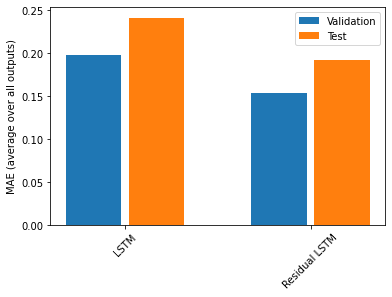

In [49]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [50]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

LSTM           : 0.2414
Residual LSTM  : 0.1925
